In [265]:
from sklearn import svm,metrics
from sklearn.model_selection import train_test_split #데이터 전처리 - train, test 분리 random_state=42
from sklearn.neighbors import KNeighborsClassifier #분류/ 데이터 학습하기
from sklearn.neighbors import KNeighborsRegressor  #회귀 예측
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression #선형회귀
from sklearn.preprocessing import PolynomialFeatures #끝난 뒤 특성을 추가해서 모델을 적용
from sklearn.preprocessing import StandardScaler #표준화작업 (instead of 데이터값 - 평균/ 표준편차)
from sklearn.linear_model import Ridge #릿지회귀
from scipy.special import softmax # 행 하나하나 1로 맞춤
from sklearn.linear_model import LogisticRegression #로지스틱 - 맞출 확률을 나타내는 것(1에 가깝게)
from sklearn.linear_model import SGDClassifier #경사하강법 - 머신러닝을 훈련하는 방법, 다 끝나고 정답률 높이기 위해 
from sklearn.model_selection import cross_validate # 머신러닝 - cross_validate
from statsmodels.stats.outliers_influence import variance_inflation_factor #회귀분석 예측 - 고려사항 체크
import statsmodels.api as sm # train set 평가서 볼 수 있는 모듈
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import oracledb
import random
import glob,os.path,re
import seaborn as sns
matplotlib.rcParams['axes.unicode_minus'] = False  # 마이너스 표시 해결
# 한글설정
matplotlib.rcParams['font.family'] = 'Malgun Gothic' # windows 사용자
# matplotlib.rcParams['font.family'] = 'AppleGothic Gothic' # Mac사용자
matplotlib.rcParams['font.size'] = '10' # 글자크기

타이나틱의 생존자 분류 모델을 구현하시오

In [266]:
df_train = pd.read_csv('titanic_train.csv')
df_train

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.00,0,1,250644,19.5000,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.00,1,1,29103,23.0000,NaN,S,NaN,"Cornwall / Akron, OH"
2,2,1,"Duran y More, Miss. Florentina",female,30.00,1,0,SC/PARIS 2148,13.8583,NaN,C,NaN,"Barcelona, Spain / Havana, Cuba"
3,3,0,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q,NaN,NaN
4,3,1,"Bradley, Miss. Bridget Delia",female,22.00,0,0,334914,7.7250,NaN,Q,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,3,1,"Dean, Miss. Elizabeth Gladys ""Millvina""",female,0.17,1,2,C.A. 2315,20.5750,NaN,S,NaN,"Devon, England Wichita, KS"
912,3,0,"Guest, Mr. Robert",male,NaN,0,0,376563,8.0500,NaN,S,NaN,NaN
913,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,NaN,NaN
914,2,1,"Sincock, Miss. Maude",female,20.00,0,0,C.A. 33112,36.7500,NaN,S,NaN,"Cornwall / Hancock, MI"


In [267]:
# 생존(survived,body)이 target, 나머지는 data
# body는 none이라서 삭제하고 survived만 씀
# 분류: knn, 로지스틱, 랜덤포레스트 

# 1. 데이터 확인: nan, 0, 타입을 확인해야 함.
# 2. 데이터 전처리 어떻게 할 것인지...
# 3. train, test 분리

# 각각의 모델을 적용
# 정답률 체크

In [268]:
df_train.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'body', 'home.dest'],
      dtype='object')

In [269]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     916 non-null    int64  
 1   survived   916 non-null    int64  
 2   name       916 non-null    object 
 3   sex        916 non-null    object 
 4   age        741 non-null    float64
 5   sibsp      916 non-null    int64  
 6   parch      916 non-null    int64  
 7   ticket     916 non-null    object 
 8   fare       916 non-null    float64
 9   cabin      214 non-null    object 
 10  embarked   914 non-null    object 
 11  body       85 non-null     float64
 12  home.dest  527 non-null    object 
dtypes: float64(3), int64(4), object(6)
memory usage: 93.2+ KB


In [277]:
df_train['age'].fillna(df_train['age'], inplace=True)
df_train['cabin'].fillna('N', inplace=True)
df_train['embarked'].fillna('N',inplace=True)

In [278]:
df_train['cabin'] = df_train['cabin'].str[:1]

<Axes: xlabel='sex', ylabel='survived'>

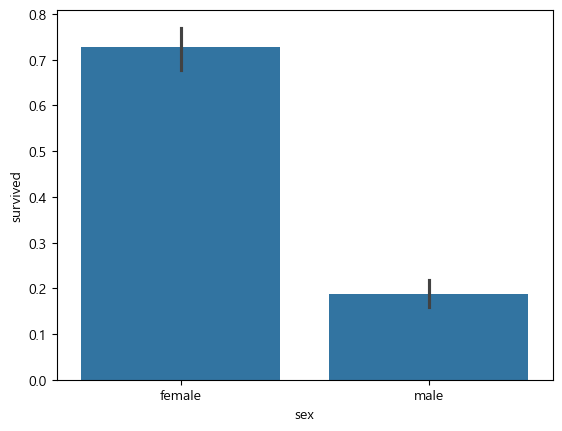

In [279]:
sns.barplot(x='sex', y='survived', data = df_train)

In [280]:
from sklearn import preprocessing

def encode_features(df_train):
    features = ['cabin', 'sex', 'embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le.fit(df_train[feature])
        df_train[feature] = le.transform(df_train[feature])
    return df_train

In [281]:
df_train=encode_features(df_train)
df_train.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",0,13.000000,0,1,250644,19.5000,7,3,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",0,4.000000,1,1,29103,23.0000,7,3,NaN,"Cornwall / Akron, OH"
2,2,1,"Duran y More, Miss. Florentina",0,30.000000,1,0,SC/PARIS 2148,13.8583,7,0,NaN,"Barcelona, Spain / Havana, Cuba"
3,3,0,"Scanlan, Mr. James",1,30.231444,0,0,36209,7.7250,7,2,NaN,NaN
4,3,1,"Bradley, Miss. Bridget Delia",0,22.000000,0,0,334914,7.7250,7,2,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."


In [300]:
input = df_train.iloc[:,:-11].to_numpy()

In [326]:
input1 = df_train.iloc[:,:-10].to_numpy()
pd.get_dummies(df_train['name'])

,"Abbing, Mr. Anthony","Abbott, Mr. Rossmore Edward","Abbott, Mrs. Stanton (Rosa Hunt)","Abelseth, Miss. Karen Marie","Abelseth, Mr. Olaus Jorgensen","Abelson, Mr. Samuel","Abelson, Mrs. Samuel (Hannah Wizosky)","Abrahamsson, Mr. Abraham August Johannes","Abrahim, Mrs. Joseph (Sophie Halaut Easu)","Aks, Master. Philip Frank",...,"Zakarian, Mr. Ortin","de Brito, Mr. Jose Joaquim","de Messemaeker, Mr. Guillaume Joseph","de Pelsmaeker, Mr. Alfons","del Carlo, Mr. Sebastiano","del Carlo, Mrs. Sebastiano (Argenia Genovesi)","van Billiard, Master. James William","van Billiard, Master. Walter John","van Billiard, Mr. Austin Blyler","van Melkebeke, Mr. Philemon"
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
912,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
913,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
914,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [301]:
target = df_train['survived'].to_numpy()
x = df_train.drop('survived',axis=1, inplace=False).to_numpy()

In [302]:
train_input,test_input,train_target,test_target = train_test_split(
    input, target,random_state=42
)

In [303]:
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [304]:
lr = LogisticRegression()
lr.fit(train_scaled, train_target)

LogisticRegression()

In [309]:
print('train 로지스틱: ',lr.score(train_scaled, train_target))
print('test 로지스틱: ',lr.score(test_scaled, test_target))

train 로지스틱:  1.0
test 로지스틱:  1.0


In [310]:
lr = LinearRegression()
lr.fit(train_input, train_target)

LinearRegression()

In [312]:
print('train 선형: ',lr.score(train_input,train_target))
print('test 선형: ',lr.score(test_input, test_target))

train 선형:  1.0
test 선형:  1.0


In [313]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=1, random_state=42)
scores = cross_validate(rf,train_input, train_target,
                        return_train_score=True,n_jobs=1)

In [316]:
print('랜덤포레스트: ',np.mean(scores['train_score']),np.mean(scores['test_score']))

랜덤포레스트:  1.0 1.0
